# Pneumonia database definition

## Functions and directories

```bash
    ~/Data/cxr  tree -L 3                                                                                                                                                      ✔  base   66%   59.13G  
.
├── CC-CXRI
│   ├── images
│   │   ├── ChestDx
│   │   ├── ChestDx_PE
│   │   ├── Normal_controls
│   │   ├── Other_pneumonia
│   │   └── Viral_pneumonia
│   └── metadata
│       ├── chest_dx.csv
│       └── viral_pneumonia_COVID-19.csv
├── CheXpert
│   └── CheXpert-v1.0-small
│       ├── train
│       ├── train.csv
│       ├── valid
│       └── valid.csv
├── kaggle
│   ├── chest_xray
│   │   ├── chest_xray
│   │   ├── __MACOSX
│   │   ├── test
│   │   ├── train
│   │   └── val
│   ├── COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset
│   │   ├── covid
│   │   ├── normal
│   │   └── pneumonia
│   └── vinbigdata-chest-xray-abnormalities-detection
│       ├── sample_submission.csv
│       ├── test
│       ├── train
│       └── train.csv
└── physionet
    ├── mimic-cxr-jpg
    │   └── 2.0.0
    └── mimic-cxr_only_reports
        └── 2.0.0

31 directories, 6 files
```

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
from wand.image import Image

In [2]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [3]:
DATA_DIR = '/home/fpozoc/Data/cxr'

In [4]:
def annotate_train_test_val_60_20_20(df:pd.DataFrame)->pd.DataFrame():
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    train['batch'] = 'train'
    val['batch'] = 'val'
    test['batch'] = 'test' 
    return pd.concat([train, val, test], axis=0).reset_index(drop=True)

def balance_binary_df(df:pd.DataFrame)->pd.DataFrame():
    if df.loc[df['pneumonia'] == 0].shape[0] > df.loc[df['pneumonia'] == 1].shape[0]:
        return pd.concat([df.loc[df['pneumonia'] == 0].sample(df.loc[df['pneumonia'] == 1].shape[0]), df.loc[df['pneumonia'] == 1]], axis=0).reset_index(drop=True)
    else:
        return pd.concat([df.loc[df['pneumonia'] == 1].sample(df.loc[df['pneumonia'] == 0].shape[0]), df.loc[df['pneumonia'] == 0]], axis=0).reset_index(drop=True)

def preprocess_db(df:pd.DataFrame)->pd.DataFrame():
    df = annotate_train_test_val_60_20_20(df)
    return balance_binary_df(df)

def barplot_labels(df:pd.DataFrame, title:str=None, savefig:bool=False, annotation:str=None)->object:
    plt.figure(figsize=(14, 7))
    plt.title(title)
    plt.style.use('ggplot')
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(data=df.transpose(), orient='h', color='lightblue')
    for p in ax.patches:
        width = p.get_width()
        plt.text(4000+p.get_width(), p.get_y()+0.55*p.get_height(), '{:1.0f}'.format(width), ha='center', va='center')
    ax.set(xlabel='number of Chest X-ray images', ylabel='')
    if savefig == True:
        plt.savefig(f'figures/barplot_{annotation}.png', bbox_inches='tight')
        
def heatmap_labels(df:pd.DataFrame, title:str=None, savefig:bool=False, annotation:str=None) -> object:
    plt.figure(figsize=(10,8))
    plt.title(title)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    data = df.T.sort_index(ascending=True).T.corr(method ='pearson')
    sns.heatmap(
            data=data.round(2),  # our correlation matrix
            linewidths=0.3,  # the width of lines separating the matrix squares
            square=True,   # enforce 1:1 ratios among correlation cells
            cmap=cmap,  # use the color map we defined above
            vmax=1,  # define the max of our correlation scale
            vmin=-1, # define the min of our correlation scale
            center=0,  # The value at which the color map is centered about (white)
            cbar_kws={"shrink": .75},  # shrink the scale a bit
            annot=True
        )
    plt.ylim(0, data.shape[0])
    plt.yticks(rotation=0)  
    if savefig == True:
        plt.savefig(f'figures/heatmap_{annotation}.png', bbox_inches='tight')

## Databases

### CC-CXRI

Paper: https://www.nature.com/articles/s41551-021-00704-1

Data: https://miracle.grmh-gdl.cn/chest_xray_ai/

```bash
├── CC-CXRI
│   ├── images
│   │   ├── ChestDx
│   │   ├── ChestDx_PE
│   │   ├── Normal_controls
│   │   ├── Other_pneumonia
│   │   └── Viral_pneumonia
│   └── metadata
│       ├── chest_dx.csv
│       └── viral_pneumonia_COVID-19.csv
```

In [5]:
df_cccxri_chest_dx = pd.read_csv(Path(DATA_DIR, 'CC-CXRI/metadata/chest_dx.csv'))
df_cccxri_chest_dx['path'] = [str(Path(DATA_DIR, 'CC-CXRI/images/ChestDx', dirname, filename)) if dirname.startswith('ChestDx-') else str(Path(DATA_DIR, 'CC-CXRI/images/ChestDx_PE', dirname, filename)) for filename, dirname in zip(df_cccxri_chest_dx['image'], df_cccxri_chest_dx['zip'])]

df_cccxri_chest_dx['exist'] = [Path(filename).exists() for filename in df_cccxri_chest_dx['path']]
df_cccxri_chest_dx = df_cccxri_chest_dx.drop('exist', axis=1)

df_cccxri_chest_dx.sample(5)

,image,zip,Consolidation,Fibrosis,Nodule,Hernia,Atelectasis,Pneumothorax,Edema,Pneumonia,Emphysema,Effusion,Infiltration,Pleural_thickening,Mass,Cardiomegaly,No_finding,path
102157,patient10710576_000.jpg,ChestDx-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...
53560,patient10927953_000.jpg,ChestDx-47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...
33022,patient10859976_000.jpg,ChestDx-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...
6217,patient10795421_000.jpg,ChestDx-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...
34018,patient10892259_000.jpg,ChestDx-40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...


Once we have loaded our dataframes in `df_cccxri_chest_dx` we want to load our data our controls (`Normal_controls` + `No_finding` labels) and both pneumonia folders: `Other_pneumonia` and `Viral_pneumonia`. We take both COVID-19 pneumonia and non-covid ones to get the best variability for our predictions.

In [6]:
df_cccxri_viral_pneumonia = pd.read_csv(Path(DATA_DIR, 'CC-CXRI/metadata/viral_pneumonia_COVID-19.csv'))
df_cccxri_viral_pneumonia.sample(5)

,image,COVID-19
628,patient38365_000.jpg,False
1791,patient38075_000.jpg,False
1917,patient300_000.jpg,True
1781,patient38410_000.jpg,False
220,patient19068_000.jpg,False


In [7]:
pneumonia_chestdx = list(df_cccxri_chest_dx.loc[df_cccxri_chest_dx['Pneumonia'] == 1].loc[df_cccxri_chest_dx['No_finding'] == 0]['path'].values)
other_pneumonia = glob(str(Path(DATA_DIR, 'CC-CXRI/images/Other_pneumonia/*/*.jpg')))
viral_pneumonia = glob(str(Path(DATA_DIR, 'CC-CXRI/images/Viral_pneumonia/*/*.jpg')))

no_finding = list(df_cccxri_chest_dx.loc[df_cccxri_chest_dx['Pneumonia'] == 0].loc[df_cccxri_chest_dx['No_finding'] == 1]['path'].values)
normal = glob(str(Path(DATA_DIR, 'CC-CXRI/images/Normal_controls/*/*.jpg')))
no_pneumonia = list(df_cccxri_chest_dx.loc[df_cccxri_chest_dx['Pneumonia'] == 0].loc[df_cccxri_chest_dx['No_finding'] == 0]['path'].values)

In [8]:
pneumonia_cccxri = pneumonia_chestdx + other_pneumonia + viral_pneumonia # definir en metodos
control_cccxri = no_finding + normal # definimos diagnosticos nulos, controles y hallazgos radiológicos diferentes de pneumonia

In [9]:
len(control_cccxri)

129343

In [10]:
len(pneumonia_cccxri)

19790

Generating signatures to check if every image is unique.

In [11]:
# df_cccxri['signature_id'] = [Image(filename=path).signature for path in df_cccxri['path']]
# df_cccxri.to_csv('databases/ccxri_pneumonia.signatures.tsv.gz', sep='\t', compression='gzip')

#### Labels heatmap

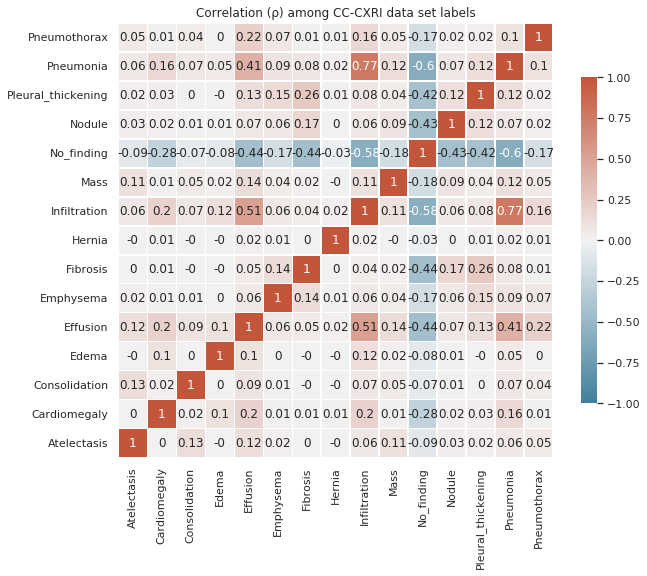

In [12]:
heatmap_labels(df_cccxri_chest_dx.iloc[:, 2:-1], title='Correlation (ρ) among CC-CXRI data set labels', savefig=True, annotation='cccxr', )

#### Labels distribution

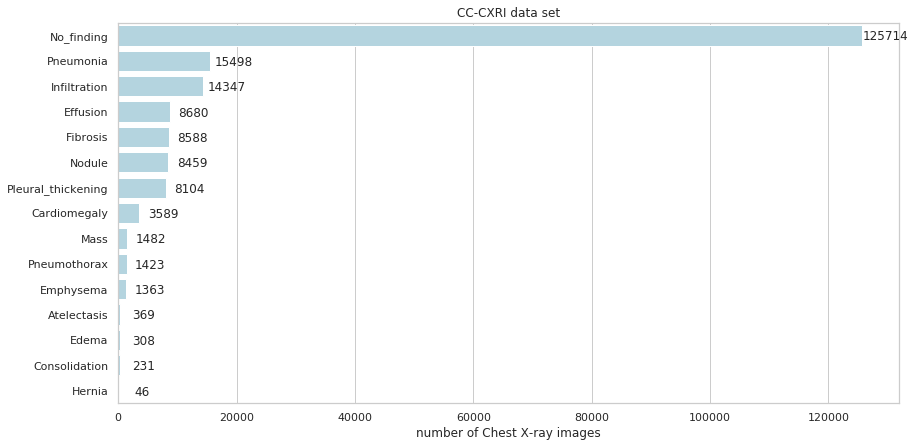

In [13]:
barplot_labels(df_cccxri_chest_dx.iloc[:, 2:-1].sum().reset_index().rename(columns={'index': 'name', 0: 'value'}).sort_values(by='value', ascending=False).set_index('name'), 
               title='CC-CXRI data set', savefig=True, annotation='cccxr')

#### Pneumonia database

In [14]:
df_cccxri_pneumonia = pd.DataFrame(pneumonia_cccxri, columns=['path'])
df_cccxri_pneumonia['pneumonia'] = 1
df_cccxri_control = pd.DataFrame(control_cccxri, columns=['path'])
df_cccxri_control['pneumonia'] = 0
df_cccxri = pd.concat([df_cccxri_pneumonia, df_cccxri_control], axis=0)
df_cccxri['source'] = 'CC-CXRI'

In [15]:
df_cccxri['pneumonia'].value_counts()

0    129343
1     19790
Name: pneumonia, dtype: int64

### MIMIC-cxr

In [16]:
# Once samples has been downloaded create a folder and make massive symbolic links

# mimic_cxr_images_dir = '/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/2.0.0/images'
# !mkdir -p mimic_cxr_images_dir
# [Path(mimic_cxr_images_dir, f'{Path(filepath).name}').symlink_to(Path(filepath)) for filepath in glob('/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/2.0.0/files/p*/p*/s*/*.jpg')]

In [17]:
len(glob('/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/2.0.0/files/p*/p*/s*/*.jpg'))

377110

Paper: https://arxiv.org/pdf/1901.07042.pdf

Webpage: https://physionet.org/content/mimic-cxr-jpg/2.0.0/

Label annotation codes used for MIMIC-cxr-jpg (from CheXpert):

    1.0 - The label was positively mentioned in the associated study, and is present in one or more of the corresponding images
        e.g. "A large pleural effusion"
    0.0 - The label was negatively mentioned in the associated study, and therefore should not be present in any of the corresponding images
        e.g. "No pneumothorax."
    -1.0 - The label was either: (1) mentioned with uncertainty in the report, and therefore may or may not be present to some degree in the corresponding image, or (2) mentioned with ambiguous language in the report and it is unclear if the pathology exists or not
        Explicit uncertainty: "The cardiac size cannot be evaluated."
        Ambiguous language: "The cardiac contours are stable."
    Missing (empty element) - No mention of the label was made in the report



In [18]:
df_mimic_cxr_chexpert = pd.read_csv(Path(DATA_DIR, 'physionet/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv'))
df_mimic_cxr_chexpert.sample(5)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
103571,14566045,52376077,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,0.0,0.0
217049,19540168,55031296,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
127127,15566609,56303038,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,0.0,NaN
94882,14174955,57213919,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
72690,13199702,54683230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [19]:
df_mimic_cxr_metadata = pd.read_csv(Path(DATA_DIR, 'physionet/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv'))
df_mimic_cxr_metadata = df_mimic_cxr_metadata[df_mimic_cxr_metadata['ViewCodeSequence_CodeMeaning'] == 'antero-posterior']
df_mimic_cxr_metadata.sample(5)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
49129,6bc9e5bf-b5219614-dea38ea2-5e06c357-6f5d8f96,11328158,59768318,CHEST (PORTABLE AP),AP,2856,2539,21830309,75231.890,CHEST (PORTABLE AP),antero-posterior,Erect
189690,b6b531b9-c8c22a0b-4abd2e68-953ee6d2-adb23468,15050125,57387048,CHEST (PORTABLE AP),AP,3056,2540,21360331,202841.906,CHEST (PORTABLE AP),antero-posterior,Recumbent
308015,ecf85350-7dba9124-5a25486a-1b43a48c-71a7945d,18156013,56038407,CHEST (PORTABLE AP),AP,3050,2539,21500810,110709.125,CHEST (PORTABLE AP),antero-posterior,Erect
298612,f3b788d5-d93932f8-cec1234e-2e1af3bc-7aaaf280,17932582,53071862,CHEST (PORTABLE AP),AP,3056,2544,21260602,60239.875,CHEST (PORTABLE AP),antero-posterior,Recumbent
315106,10ce03f1-537622ee-04f82c89-60cffb02-cae19b81,18343701,58894919,CHEST (PORTABLE AP),AP,2964,2503,21630713,82655.640,CHEST (PORTABLE AP),antero-posterior,Erect


In [20]:
df_mimic_cxr_negbio = pd.read_csv(Path(DATA_DIR, 'physionet/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-negbio.csv'))
df_mimic_cxr_negbio.sample(5)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
55122,12414025,53928860,-1.0,NaN,NaN,-1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0
17179,10771901,58060973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
144385,16320616,53221133,-1.0,-1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN
174229,17643850,58528265,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,NaN
78722,13468163,57713670,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,1.0


In [21]:
df_mimic_cxr_split = pd.read_csv(Path(DATA_DIR, 'physionet/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-split.csv'))
df_mimic_cxr_split.sample(5)

,dicom_id,study_id,subject_id,split
259850,3ef1af0b-d44a03dc-196c548f-d44f5429-05239a01,58188864,16900914,train
303587,8efe1e3a-0cb6e8e8-7f83e5a0-ba19ff01-dab8bdbc,50602719,18044722,train
210163,de7d3342-84e46985-6a700743-2f084821-a8e7653b,55344259,15564338,train
376765,b1ed27a3-2b5f2acc-c2c02f5b-462ebb9c-cb8a6983,57912514,19993776,train
28146,1ec0c29e-b231e5ab-ded91c7f-00f9bcfe-ec4d536c,58272725,10764758,train


In [22]:
my_dict = {}
for col in df_mimic_cxr_chexpert[df_mimic_cxr_chexpert.columns[2:-1]].columns:
    my_dict[col] = df_mimic_cxr_chexpert[df_mimic_cxr_chexpert.columns[2:-1]].astype('category')[col].value_counts().to_dict()
df_mimic_cxr_chexpert_labels = pd.DataFrame(my_dict).T.rename(columns={1:'Positively mentioned', 0:'Negatively mentioned', -1: 'Uncertainty'})

df_mimic_cxr_chexpert_percentages = df_mimic_cxr_chexpert_labels.copy()
df_mimic_cxr_chexpert_percentages['Positively mentioned'] = (df_mimic_cxr_chexpert_percentages['Positively mentioned']/df_mimic_cxr_chexpert_labels.sum(axis=1))*100
df_mimic_cxr_chexpert_percentages['Uncertainty'] = (df_mimic_cxr_chexpert_percentages['Uncertainty']/df_mimic_cxr_chexpert_labels.sum(axis=1))*100
df_mimic_cxr_chexpert_percentages['Negatively mentioned'] = (df_mimic_cxr_chexpert_percentages['Negatively mentioned']/df_mimic_cxr_chexpert_labels.sum(axis=1))*100

#### Heatmap

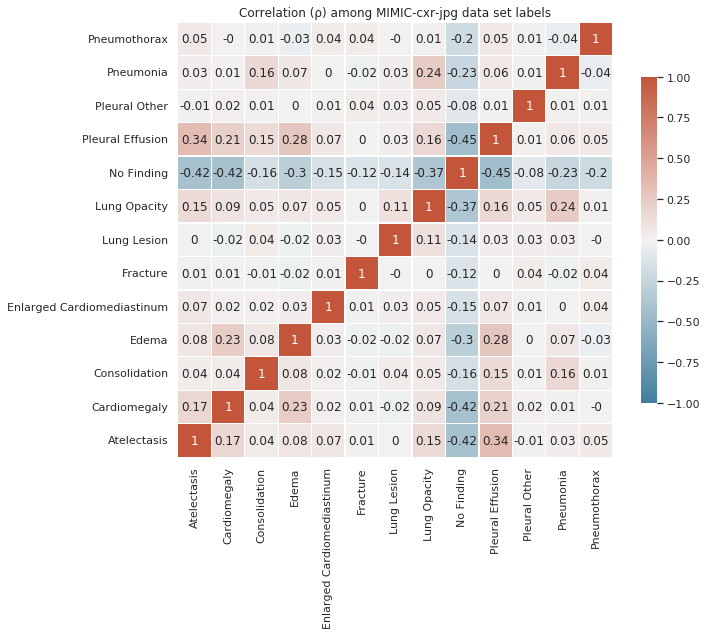

In [23]:
# I discard the uncertainty images t (label = -1)
heatmap_labels(df_mimic_cxr_chexpert[df_mimic_cxr_chexpert.columns[2:-1]].fillna(0).replace(-1, np.nan).dropna(axis=0), 
               title='Correlation (ρ) among MIMIC-cxr-jpg data set labels', savefig=True, annotation='chexpert')

#### Percentage of uncertainty

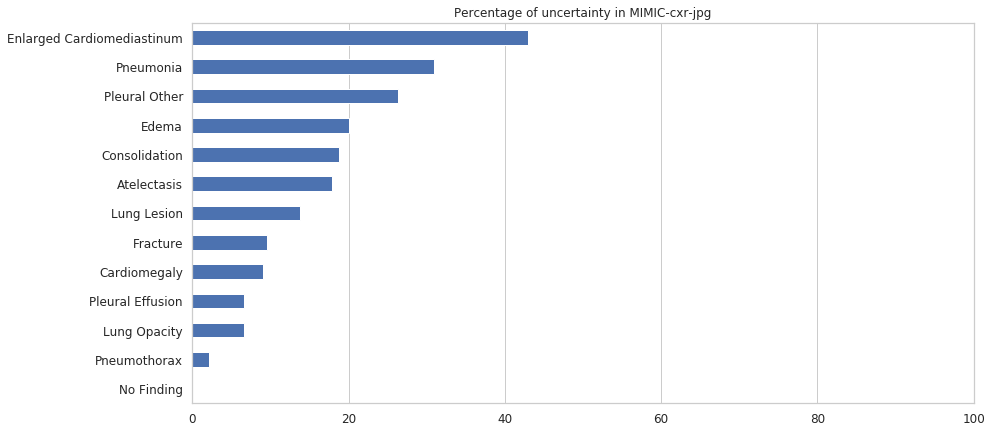

In [24]:
plt.figure(figsize=(14, 7))
plt.title('Percentage of uncertainty in MIMIC-cxr-jpg')
df_mimic_cxr_chexpert_percentages.round(2)['Uncertainty'].fillna(0).sort_values().plot(kind='barh', fontsize=12)
plt.grid(axis='y')
plt.xlim(0,100)
plt.savefig(f'figures/uncertainty_mimic-cxr.png', bbox_inches='tight')
plt.show()
plt.close()

#### Number of annotations

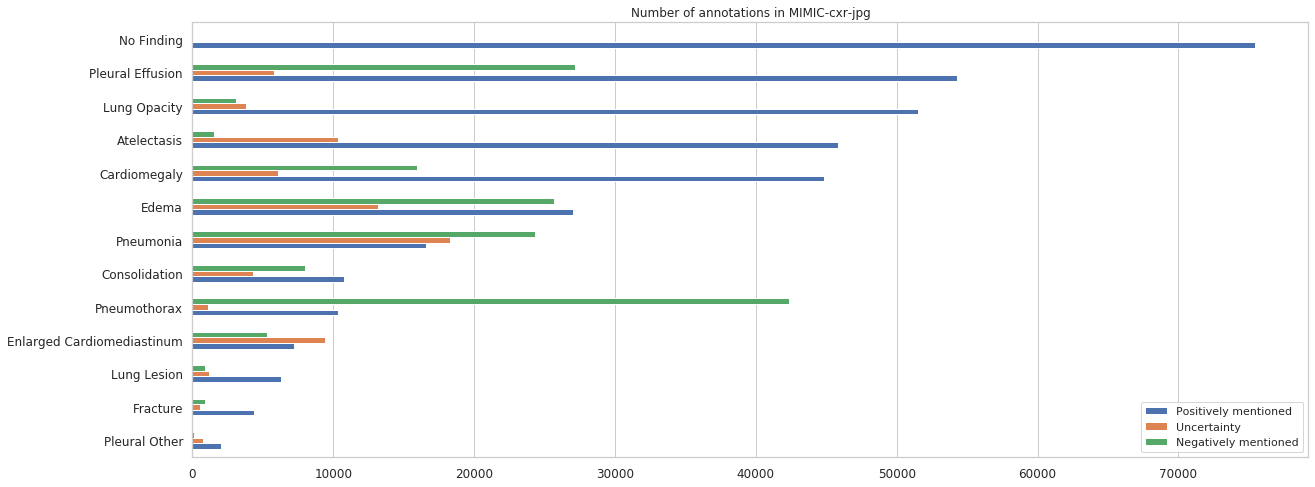

In [25]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
df_mimic_cxr_chexpert_labels.sort_values(by='Positively mentioned', ascending=True).plot(kind='barh', figsize=(20,8), fontsize=12, title='Number of annotations in MIMIC-cxr-jpg')
plt.savefig(f'figures/labels_annotations_mimic-cxr.png', bbox_inches='tight')
plt.grid(axis='y')

In [26]:
# creating database with non-uncertainty labels
mimic_cxr_dir = "/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/2.0.0/files"
df_mimic_cxr = pd.merge(df_mimic_cxr_metadata[['dicom_id', 'subject_id', 'study_id']], df_mimic_cxr_chexpert.fillna(0).replace(-1, np.nan).dropna(axis=0), on=['study_id', 'subject_id'])
df_mimic_cxr['path'] = df_mimic_cxr['path'] = [str(Path(mimic_cxr_dir, str(f"p{subject_id}")[:3], str(f"p{subject_id}"), str(f"s{study_id}"), f"{dicom_id}.jpg"))
                                               for dicom_id, subject_id, study_id in zip(df_mimic_cxr['dicom_id'], df_mimic_cxr['subject_id'], df_mimic_cxr['study_id'])]
df_mimic_cxr['exist'] = [Path(filename).exists() for filename in df_mimic_cxr['path']]

In [27]:
pneumonia_mimic = list(df_mimic_cxr[df_mimic_cxr['Pneumonia'] == 1]['path'])
control_mimic = list(df_mimic_cxr[df_mimic_cxr['Pneumonia'] != 1]['path'])

In [28]:
# creating signatures to drop duplicates

# df_mimic_cxr['signature_id'] = [Image(filename=path).signature for path in df_mimic_cxr['path']]
# df_mimic_cxr.to_csv('databases/mimic_cxr.signatures.tsv.gz', sep='\t', compression='gzip')

#### Pneumonia database

In [29]:
df_mimic_pneumonia = pd.DataFrame(pneumonia_mimic, columns=['path'])
df_mimic_pneumonia['pneumonia'] = 1
df_mimic_control = pd.DataFrame(control_mimic, columns=['path'])
df_mimic_control['pneumonia'] = 0
df_mimic = pd.concat([df_mimic_pneumonia, df_mimic_control], axis=0)
df_mimic['source'] = 'MIMIC-cxr-jpg'

In [30]:
df_mimic['pneumonia'].value_counts()

0    97182
1     7282
Name: pneumonia, dtype: int64

### ChexPert

Paper: https://arxiv.org/pdf/1901.07031.pdf

Repo: https://stanfordmlgroup.github.io/competitions/chexpert/

In [31]:
df_chexpert_train = pd.read_csv(Path(DATA_DIR, 'CheXpert/CheXpert-v1.0-small/train.csv'))

In [32]:
df_chexpert_train = pd.read_csv(Path(DATA_DIR, 'CheXpert/CheXpert-v1.0-small/train.csv'))
df_chexpert_train['batch'] = 'train'
df_chexpert_valid = pd.read_csv(Path(DATA_DIR, 'CheXpert/CheXpert-v1.0-small/valid.csv'))
df_chexpert_valid['batch'] = 'valid'
df_chexpert_labels = pd.concat([df_chexpert_train, df_chexpert_valid], axis=0)
df_chexpert_labels['path'] = [str(Path(DATA_DIR, 'CheXpert', filename)) for filename in df_chexpert_labels['Path']]
df_chexpert_labels.sample(3)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,batch,path
100066,CheXpert-v1.0-small/train/patient24086/study3/...,Male,36,Frontal,PA,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,train,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...
109629,CheXpert-v1.0-small/train/patient26331/study4/...,Female,65,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,train,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...
185701,CheXpert-v1.0-small/train/patient44063/study1/...,Female,84,Frontal,AP,NaN,NaN,-1.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,train,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...


In [33]:
# df_chexpert_labels['signature_id'] = [Image(filename=path).signature for path in df_chexpert_labels['path']]
# df_chexpert_labels.to_csv('databases/chexpert.signatures.tsv.gz', sep='\t', compression='gzip')

#### Labels heatmap

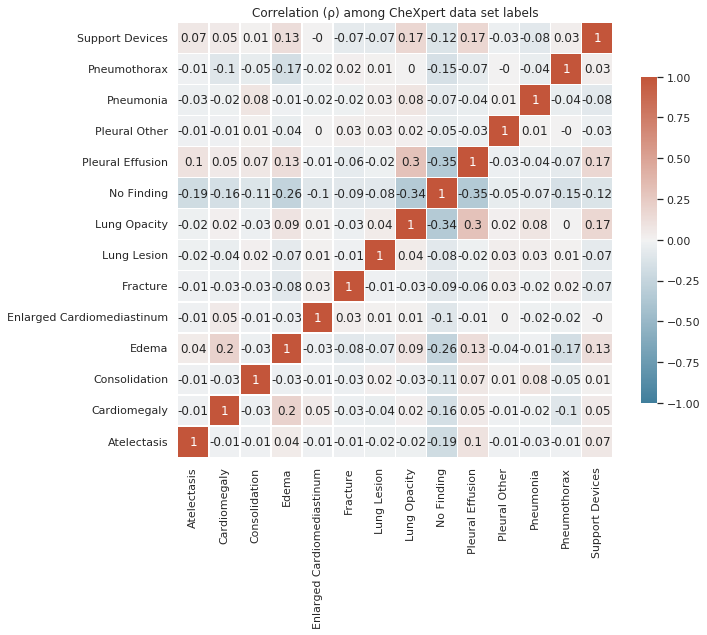

In [34]:
heatmap_labels(df_chexpert_labels[df_chexpert_labels['Frontal/Lateral'] == 'Frontal'].iloc[:, 5:-2].fillna(0).replace(-1, np.nan).dropna(axis=0), 
               title='Correlation (ρ) among CheXpert data set labels', savefig=True, annotation='chexpert')

In [35]:
# my_dict = {}
for col in df_chexpert_labels[df_chexpert_labels['Frontal/Lateral'] == 'Frontal'].iloc[:, 5:-2].columns:
    my_dict[col] = df_chexpert_labels[df_chexpert_labels['Frontal/Lateral'] == 'Frontal'].iloc[:, 5:-2].astype('category')[col].value_counts().to_dict()
df_chexpert_labelscat = pd.DataFrame(my_dict).T.rename(columns={1:'Positively mentioned', 0:'Negatively mentioned', -1: 'Uncertainty'})

df_chexpert_percentages = df_chexpert_labelscat.copy()
df_chexpert_percentages['Positively mentioned'] = (df_chexpert_percentages['Positively mentioned']/df_chexpert_labelscat.sum(axis=1))*100
df_chexpert_percentages['Uncertainty'] = (df_chexpert_percentages['Uncertainty']/df_chexpert_labelscat.sum(axis=1))*100
df_chexpert_percentages['Negatively mentioned'] = (df_chexpert_percentages['Negatively mentioned']/df_chexpert_labelscat.sum(axis=1))*100

#### Percentage of uncertainty

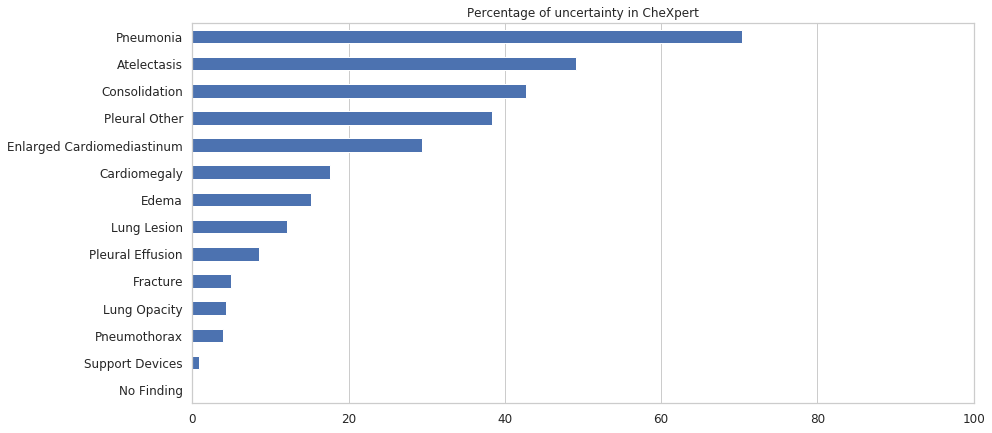

In [36]:
plt.figure(figsize=(14, 7))
plt.title('Percentage of uncertainty in CheXpert')
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
df_chexpert_percentages.round(2)['Uncertainty'].fillna(0).sort_values().plot(kind='barh', fontsize=12)
plt.grid(axis='y')
plt.xlim(0,100)
plt.savefig(f'figures/uncertainty_chexpert.png', bbox_inches='tight')
plt.show()
plt.close()

En esta imagen vemos que hay una amplia incertidumbre a la hora de etiquetar pneumonias

#### Number of annotations

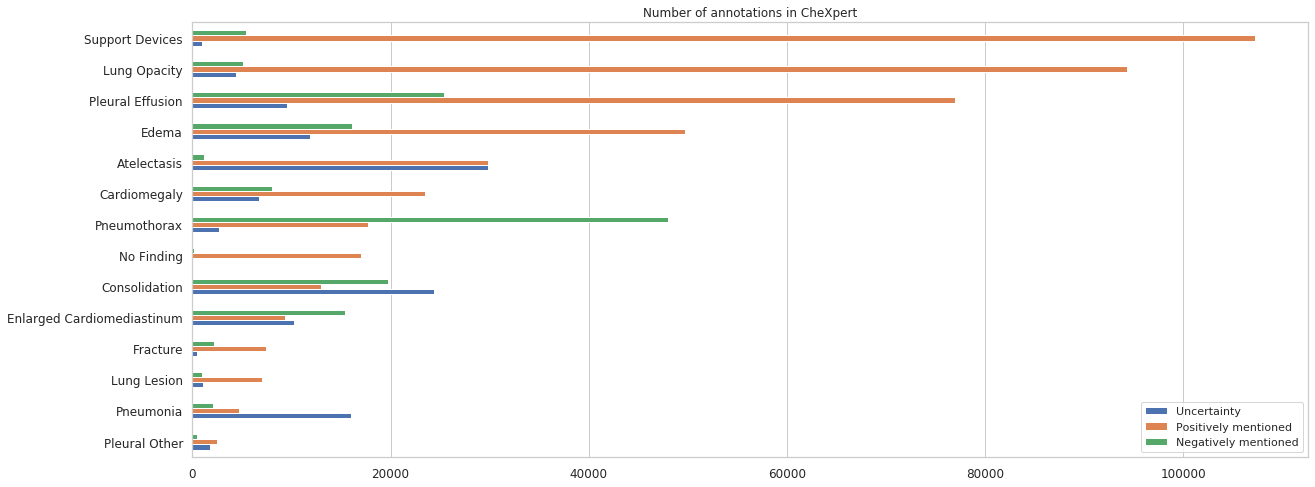

In [37]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
df_chexpert_labelscat.sort_values(by='Positively mentioned', ascending=True).plot(kind='barh', figsize=(20,8), fontsize=12, title='Number of annotations in CheXpert')
plt.savefig(f'figures/labels_annotations_chexpert.png', bbox_inches='tight')
plt.grid(axis='y')

In [38]:
df_chexpert_labels_uc = df_chexpert_labels.fillna(0).replace(-1, np.nan).dropna(axis=0)

In [39]:
df_chexpert_labels_pneumonia = df_chexpert_labels_uc.loc[df_chexpert_labels_uc['Pneumonia'] == 1]
df_chexpert_labels_pneumonia_frontal = df_chexpert_labels_pneumonia.loc[df_chexpert_labels_pneumonia['Frontal/Lateral'] == 'Frontal']

df_chexpert_labels_no_findings = df_chexpert_labels_uc.loc[df_chexpert_labels_uc['No Finding'] == 1]
df_chexpert_labels_no_findings_frontal = df_chexpert_labels_no_findings.loc[df_chexpert_labels_no_findings['Frontal/Lateral'] == 'Frontal']

df_chexpert_labels_no_pneumonia = df_chexpert_labels_uc.loc[df_chexpert_labels_uc['Pneumonia'] == 0]
df_chexpert_labels_no_pneumonia_frontal = df_chexpert_labels_no_findings.loc[df_chexpert_labels_no_findings['Frontal/Lateral'] == 'Frontal']

In [40]:
pneumonia_chexpert = list(df_chexpert_labels_pneumonia_frontal['path'].values)
control_chexpert = list(df_chexpert_labels_no_pneumonia_frontal['path'].values)

In [41]:
len(pneumonia_chexpert)

2982

In [42]:
len(control_chexpert)

16921

#### Pneumonia database

In [86]:
df_chexpert_pneumonia = pd.DataFrame(pneumonia_chexpert, columns=['path'])
df_chexpert_pneumonia['pneumonia'] = 1
df_chexpert_control = pd.DataFrame(control_chexpert, columns=['path'])
df_chexpert_control['pneumonia'] = 0
df_chexpert = pd.concat([df_chexpert_pneumonia, df_chexpert_control], axis=0)
df_chexpert['source'] = 'CheXpert'

In [87]:
df_chexpert['pneumonia'].value_counts()

0    16921
1     2982
Name: pneumonia, dtype: int64

In [91]:
df_chexpert

,path,pneumonia,source
0,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert
1,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert
2,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert
3,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert
4,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert
...,...,...,...
16916,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,0,CheXpert
16917,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,0,CheXpert
16918,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,0,CheXpert
16919,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,0,CheXpert


### ChestXRay kaggle 

Paper: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Webpage: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [84]:
pneumonia_chestxray_kaggle = glob(str(Path(DATA_DIR, 'kaggle/chest_xray/*/PNEUMONIA/*')))
control_chestxray_kaggle = glob(str(Path(DATA_DIR, 'kaggle/chest_xray/*/NORMAL/*')))

#### Pneumonia database

In [85]:
df_chexray_pneumonia = pd.DataFrame(pneumonia_chestxray_kaggle, columns=['path'])
df_chexray_pneumonia['pneumonia'] = 1
df_chexray_control = pd.DataFrame(control_chestxray_kaggle, columns=['path'])
df_chexray_control['pneumonia'] = 0
df_chexray = pd.concat([df_chexray_pneumonia, df_chexray_control], axis=0)
df_chexray['source'] = 'ChestXRay_kaggle'

In [47]:
df_chexray['pneumonia'].value_counts()

1    4273
0    1583
Name: pneumonia, dtype: int64

### NIH Chest X-ray dataset

https://www.kaggle.com/datasets/nih-chest-xrays/data

In [48]:
df_nih_metadata = pd.read_csv('/home/fpozoc/Data/cxr/nih/Data_Entry_2017.csv')
df_nih_metadata = df_nih_metadata.rename(columns={
    'OriginalImagePixelSpacing[x':'x', 
    'y]': 'y',
    'OriginalImage[Width': 'width',
    'Height': 'height'
}).drop('Unnamed: 11', axis=1)
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(DATA_DIR, 'nih', 'images*', '*', '*.png'))}
df_nih_metadata['path'] = df_nih_metadata['Image Index'].map(all_image_paths.get)

In [49]:
df_nih_metadata

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,Height],x,y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/home/fpozoc/Data/cxr/nih/images_001/images/00...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/home/fpozoc/Data/cxr/nih/images_001/images/00...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/home/fpozoc/Data/cxr/nih/images_001/images/00...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/home/fpozoc/Data/cxr/nih/images_001/images/00...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/home/fpozoc/Data/cxr/nih/images_001/images/00...
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,/home/fpozoc/Data/cxr/nih/images_012/images/00...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,/home/fpozoc/Data/cxr/nih/images_012/images/00...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,/home/fpozoc/Data/cxr/nih/images_012/images/00...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,/home/fpozoc/Data/cxr/nih/images_012/images/00...


#### Labels distribution

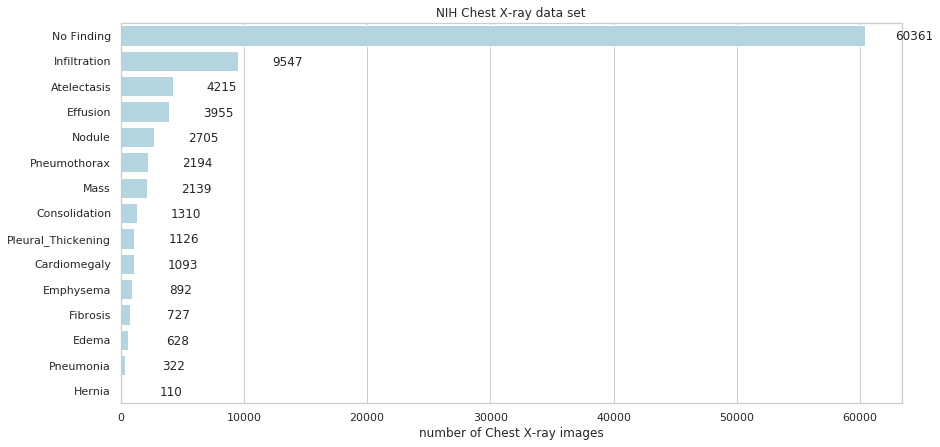

In [50]:
barplot_labels(df_nih_metadata[~df_nih_metadata['Finding Labels'].str.contains('\|')]['Finding Labels'].value_counts().reset_index().rename(columns={'index': 'name', 'Finding Labels':'value'}).set_index('name'),
              title='NIH Chest X-ray data set', annotation='nih', savefig=True)

In [51]:
pneumonia_nih = list(df_nih_metadata[df_nih_metadata['Finding Labels'].str.contains('Pneumonia')]['path'].values)
control_nih = list(df_nih_metadata[~df_nih_metadata['Finding Labels'].str.contains('Pneumonia')]['path'].values)

#### Pneumonia database

In [52]:
df_nihchexray_pneumonia = pd.DataFrame(pneumonia_nih, columns=['path'])
df_nihchexray_pneumonia['pneumonia'] = 1
df_nihchexray_control = pd.DataFrame(control_nih, columns=['path'])
df_nihchexray_control['pneumonia'] = 0
df_nihchexray = pd.concat([df_nihchexray_pneumonia, df_nihchexray_control], axis=0)
df_nihchexray['source'] = 'nih_chest_x_ray'

In [53]:
df_nihchexray['pneumonia'].value_counts()

0    110689
1      1431
Name: pneumonia, dtype: int64

### COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset

https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

In [54]:
pneumonia_covid19_kaggle = glob(str(Path(DATA_DIR, 'kaggle/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/*')))
control_covid19_kaggle = glob(str(Path(DATA_DIR, 'kaggle/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal/*')))

In [55]:
df_covid19pa_pneumonia = pd.DataFrame(pneumonia_covid19_kaggle, columns=['path'])
df_covid19pa_pneumonia['pneumonia'] = 1
df_covid19pa_control = pd.DataFrame(control_covid19_kaggle, columns=['path'])
df_covid19pa_control['pneumonia'] = 0
df_covid19pa = pd.concat([df_covid19pa_pneumonia, df_covid19pa_control], axis=0)
df_covid19pa['source'] = 'COVID19_Pneumonia_Normal_Chest_Xray_PA'

#### Pneumonia database

In [56]:
df_covid19pa['pneumonia'].value_counts()

1    1525
0    1525
Name: pneumonia, dtype: int64

### Vinbigdata (dicom)

* To do: convert dicom images to jpg 

https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection

In [39]:
df_vinbigdata_labels = pd.read_csv(Path(DATA_DIR, 'kaggle/vinbigdata-chest-xray-abnormalities-detection/train.csv'))
df_vinbigdata_labels['path'] = [str(Path(DATA_DIR, 'kaggle/vinbigdata-chest-xray-abnormalities-detection', filename+'.jpg')) for filename in df_vinbigdata_labels['image_id']]
df_vinbigdata_labels.sample(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
31734,af9a9224cf1f0dd1bacdb95a1b8ea36b,Calcification,2,R8,1384.0,736.0,1915.0,1139.0,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
6822,fd8dac9e53275d18e40ce4aa1666bc7e,No finding,14,R8,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
52334,2cb442312ff65f3255923b38dc6dc2fa,Aortic enlargement,0,R10,1593.0,526.0,2009.0,950.0,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
14059,d65dc1ea247c2f0244fbb720b7c9f515,No finding,14,R5,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
46134,dd218cc5abf3a5538e889b72f2878bf9,No finding,14,R1,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...


In [40]:
df_vinbigdata_labels[df_vinbigdata_labels['class_name'] == 'No finding']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
12,5550a493b1c4554da469a072fdfab974,No finding,14,R9,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
13,869f39afbdd8783b531530942eda8bad,No finding,14,R3,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
...,...,...,...,...,...,...,...,...,...
67905,955f258cc29153f996ee6716218c1196,No finding,14,R8,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,/home/fpozoc/Data/cxr/kaggle/vinbigdata-chest-...


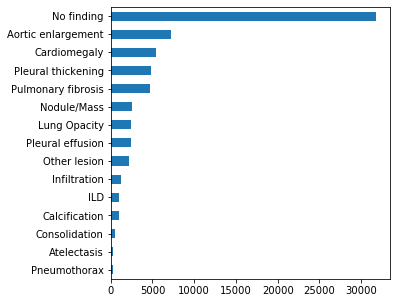

In [41]:
barplot_labels(df_vinbigdata_labels['class_name'].value_counts())

### OpenI

https://openi.nlm.nih.gov/

## Final database 

In [57]:
df_pneumonia = pd.concat([preprocess_db(df_cccxri), preprocess_db(df_mimic), preprocess_db(df_chexpert), preprocess_db(df_chexray), preprocess_db(df_nihchexray), preprocess_db(df_covid19pa)], axis=0).reset_index(drop=True)

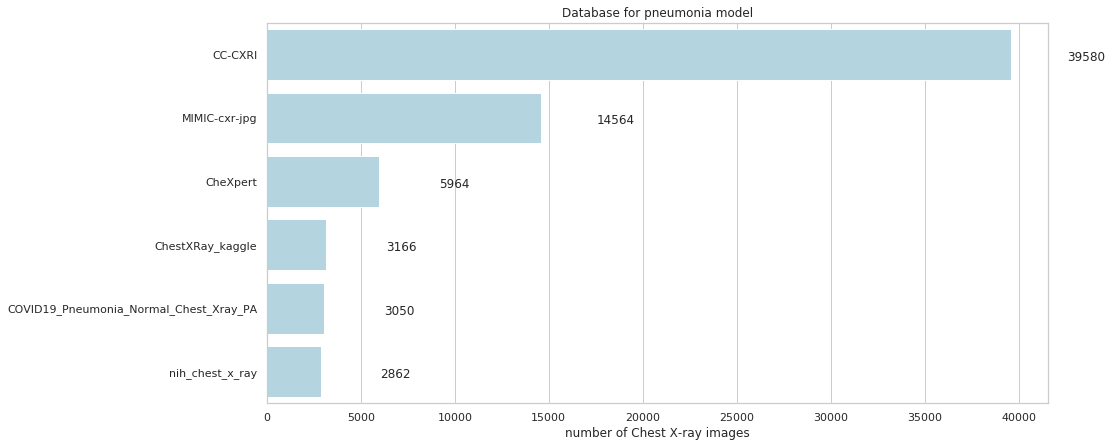

In [58]:
barplot_labels(df_pneumonia['source'].value_counts().reset_index().rename(columns={'index': 'name', 'source': 'value'}).set_index('name'), 
               title='Database for pneumonia model', annotation='full_database', savefig=True)

In [110]:
df_pneumonia['exist'] = [Path(filename).exists() for filename in df_pneumonia['path']]
print(df_pneumonia['exist'].value_counts())
df_pneumonia = df_pneumonia.drop('exist', axis=1)

True    69186
Name: exist, dtype: int64


In [116]:
df_pneumonia.sample(10)

,path,pneumonia,source,batch,src,copy_path
67710,/home/fpozoc/Data/cxr/kaggle/COVID19_Pneumonia...,0,COVID19_Pneumonia_Normal_Chest_Xray_PA,train,data/cxr/COVID19_Pneumonia_Normal_Chest_Xray_P...,/media/fpozoc/data/cxr/kaggle/COVID19_Pneumoni...
26391,/home/fpozoc/Data/cxr/CC-CXRI/images/Other_pne...,1,CC-CXRI,train,data/cxr/CC-CXRI/patient11865_000.jpg,/media/fpozoc/data/cxr/CC-CXRI/images/Other_pn...
37942,/home/fpozoc/Data/cxr/CC-CXRI/images/Viral_pne...,1,CC-CXRI,test,data/cxr/CC-CXRI/patient19246_000.jpg,/media/fpozoc/data/cxr/CC-CXRI/images/Viral_pn...
31142,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...,1,CC-CXRI,train,data/cxr/CC-CXRI/patient10805744_000.jpg,/media/fpozoc/data/cxr/CC-CXRI/images/ChestDx/...
42470,/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/...,0,MIMIC-cxr-jpg,train,data/cxr/MIMIC-cxr-jpg/bf802aca-4c2308ac-ff4ad...,/media/fpozoc/data/cxr/physionet/mimic-cxr-jpg...
19608,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...,0,CC-CXRI,train,data/cxr/CC-CXRI/patient10738503_000.jpg,/media/fpozoc/data/cxr/CC-CXRI/images/ChestDx/...
65594,/home/fpozoc/Data/cxr/nih/images_002/images/00...,1,nih_chest_x_ray,val,data/cxr/nih_chest_x_ray/00002413_001.png,/media/fpozoc/data/cxr/nih/images_002/images/0...
49956,/home/fpozoc/Data/cxr/physionet/mimic-cxr-jpg/...,1,MIMIC-cxr-jpg,train,data/cxr/MIMIC-cxr-jpg/8a4cfa50-3f3662f3-7d1c4...,/media/fpozoc/data/cxr/physionet/mimic-cxr-jpg...
57704,/home/fpozoc/Data/cxr/CheXpert/CheXpert-v1.0-s...,1,CheXpert,train,data/cxr/CheXpert/view1_frontal.jpg,/media/fpozoc/data/cxr/CheXpert/CheXpert-v1.0-...
34653,/home/fpozoc/Data/cxr/CC-CXRI/images/ChestDx/C...,1,CC-CXRI,val,data/cxr/CC-CXRI/patient10571118_001.jpg,/media/fpozoc/data/cxr/CC-CXRI/images/ChestDx/...


## Extra code

In [118]:
df_pneumonia['copy_path'] = [f"/media/fpozoc/data/{path.split('/Data/')[1]}" for path, source in zip(df_pneumonia['path'], df_pneumonia['source'])]
df_pneumonia['copy_dir'] = [str(Path(path).parents[0]) for path in df_pneumonia['copy_path']]
df_pneumonia[['path', 'copy_dir', 'copy_path']].to_csv('copy.txt', sep='\t', header=None, index=None)
# df_pneumonia['copy_path'] = [f"/media/fpozoc/data/cxr/{source}" for path, source in zip(df_pneumonia['path'], df_pneumonia['source'])]
df_pneumonia['src'] = [f"{copy_path.split('/media/fpozoc/')[-1]}" for copy_path in df_pneumonia['copy_path']]

df_pneumonia[['src', 'source', 'pneumonia', 'batch']].to_csv('~/Desktop/metadata.tsv', sep='\t', index=None)

In [127]:
# [shutil.copyfile(path, copy_path) for path, copy_path in zip(test['path'], test['copy_path'])]

# cat copy.txt | while read src dst; do sudo rsync -av --progress $src $dst; done

In [129]:
df_pneumonia['signature_id'] = [Image(filename=path).signature for path in df_pneumonia['path']]
df_pneumonia = df_pneumonia.drop_duplicates('signature_id').reset_index(drop=True)
df_pneumonia.to_csv('data/pneumonia_db.tsv.gz', sep='\t', compression='gzip')

In [154]:
[Path('/home/fpozoc/Projects/cxr-img-classifier/data/pneumonia/case', f'{Path(filepath).name}').symlink_to(Path(filepath)) for filepath in df_pneumonia[df_pneumonia['pneumonia'] == 1]['path']]
[Path('/home/fpozoc/Projects/cxr-img-classifier/data/pneumonia/control', f'{Path(filepath).name}').symlink_to(Path(filepath)) for filepath in df_pneumonia[df_pneumonia['pneumonia'] == 0]['path']]

# Author contribution

**Author information**:

Fernando Pozo

- [ORCID iD (0000-0001-7688-6045)](https://orcid.org/0000-0001-7688-6045)
- [GitHub (@fpozoc)](https://github.com/fpozoc)
- [Twitter (@fpozoca)](https://twitter.com/fpozoca)